# NLP Critique de film

## Importation des bibliothèques

In [1]:
import requests
import lxml.html as lh
import pandas as pd

## Scrapping

In [2]:
page = requests.get("https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/")
doc = lh.fromstring(page.content)

com = doc.xpath('//div[@class="content-txt review-card-content"]')
note = doc.xpath('//span[@class="stareval-note"]')

In [3]:
# for i in range(len(note)):
#     print(note[i].text_content().strip() + "\n" + \
#           com[i].text_content().strip() + "\n")

In [4]:
# URL
url = "https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/"
# URI-SUFFIX
uri_pages = '?page='
# Number of pages to read
nbPages = 100
# XPath content to collect
tags = ['//span[@class="stareval-note"]', \
        '//div[@class="content-txt review-card-content"]']

cols = ["Note", \
        "Commentaire"]

urls = ["https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/", \
        "https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/"]

In [5]:
page = requests.get(url)
doc = lh.fromstring(page.content)

In [6]:
def getPage(url):
    page = requests.get(url)
    doc = lh.fromstring(page.content)

    # Get the Web data via XPath
    content = []
    for i in range(len(tags)):
        content.append(doc.xpath(tags[i]))

    # Gather the data into a Pandas DataFrame array
    df_liste = []
    for j in range(len(tags)):
        tmp = pd.DataFrame([content[j][i].text_content().strip() for i in range(len(content[i]))], columns=[cols[j]])
        tmp['key'] = tmp.index
        df_liste.append(tmp)

    # Build the unique Dataframe with one tag (xpath) content per column
    liste = df_liste[0]
    for j in range(len(tags)-1):
        liste = liste.join(df_liste[j+1], on='key', how='left', lsuffix='_l', rsuffix='_r')
        liste['key'] = liste.index
        del liste['key_l']
        del liste['key_r']
    
    return liste

def getPages(_nbPages, _urls):
    liste_finale = pd.DataFrame()
    for _url in _urls:
        for i in range (_nbPages):
            liste = getPage(_url + uri_pages + str(i+1))
            liste_finale = pd.concat([liste_finale, liste], ignore_index=True)
        print(liste_finale.shape)
    return liste_finale

In [7]:
getPage(url).shape

(15, 3)

In [8]:
list_totale = getPages(nbPages, urls)

(1500, 3)
(2100, 3)


In [9]:
list_totale

,Note,Commentaire,key
0,"5,0",Après le chef d'oeuvre super-héroïque The Dark...,0
1,"5,0",C’est fou ce qu’on aime détester Christopher N...,1
2,"5,0",CHEF D’ŒUVRE ! Le film est absolument parfait ...,2
3,"5,0","Un film aussi novateur que complexe, dont la m...",3
4,"3,5",Le meilleur blockbuster de 2010 a pour thème l...,4
...,...,...,...
2095,"4,0","Y'a rien à dire, c'est vraiment un excellent f...",0
2096,"5,0",J'ai adoré ce film beaucoup mieux que le premi...,1
2097,"5,0",Le film est trop bien la qualité du film est s...,2
2098,"4,0",Excellent film à voir petit comme grand. J’ai ...,3


## Préparation des données

In [10]:
df = list_totale.copy()

In [11]:
df["Commentaire"] = df["Commentaire"].replace("[^\w\s]", " ", regex=True).str.replace('\d+', '', regex=True).str.lower()
df.head()

,Note,Commentaire,key
0,"5,0",après le chef d oeuvre super héroïque the dark...,0
1,"5,0",c est fou ce qu on aime détester christopher n...,1
2,"5,0",chef d œuvre le film est absolument parfait ...,2
3,"5,0",un film aussi novateur que complexe dont la m...,3
4,"3,5",le meilleur blockbuster de a pour thème la dé...,4


### Soustraction de stopwords 

In [12]:
from stop_words import get_stop_words

In [13]:
stopwords = get_stop_words('french')
print(stopwords)

['a', 'ai', 'aie', 'aient', 'aies', 'ait', 'alors', 'as', 'au', 'aucun', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'aux', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayez', 'ayons', 'bon', 'car', 'ce', 'ceci', 'cela', 'ces', 'cet', 'cette', 'ceux', 'chaque', 'ci', 'comme', 'comment', 'd', 'dans', 'de', 'dedans', 'dehors', 'depuis', 'des', 'deux', 'devoir', 'devrait', 'devrez', 'devriez', 'devrions', 'devrons', 'devront', 'dois', 'doit', 'donc', 'dos', 'droite', 'du', 'dès', 'début', 'dù', 'elle', 'elles', 'en', 'encore', 'es', 'est', 'et', 'eu', 'eue', 'eues', 'eurent', 'eus', 'eusse', 'eussent', 'eusses', 'eussiez', 'eussions', 'eut', 'eux', 'eûmes', 'eût', 'eûtes', 'faire', 'fais', 'faisez', 'fait', 'faites', 'fois', 'font', 'force', 'furent', 'fus', 'fusse', 'fussent', 'fusses', 'fussiez', 'fussions', 'fut', 'fûmes', 'fût', 'fûtes', 'haut', 'ho

In [14]:
stopwords.append("c")

In [15]:
df['sans_sw'] = df['Commentaire'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df.head()

,Note,Commentaire,key,sans_sw
0,"5,0",après le chef d oeuvre super héroïque the dark...,0,après chef oeuvre super héroïque the dark knig...
1,"5,0",c est fou ce qu on aime détester christopher n...,1,fou aime détester christopher nolan plus films...
2,"5,0",chef d œuvre le film est absolument parfait ...,2,chef œuvre film absolument parfait acteurs exc...
3,"5,0",un film aussi novateur que complexe dont la m...,3,film novateur complexe dont mise scène touche ...
4,"3,5",le meilleur blockbuster de a pour thème la dé...,4,meilleur blockbuster thème délicate différenci...


### Etape de LEM

In [16]:
import spacy

2022-06-17 09:51:04.808778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-17 09:51:04.808825: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
nlp = spacy.load('fr_core_news_md')

# doc = nlp(u"voudrais était non animaux yeux dors couvre.")
# for token in doc:
#    print(token, token.lemma_)

In [18]:
# df["lem"] = df["sans_sw"].apply(lambda x: [y.lemma_ for y in nlp(x)])
# df.head()

In [19]:
df['lem'] = df["sans_sw"].apply(lambda x: ' '.join(str(y.lemma_) for y in nlp(x)))
df.head()

,Note,Commentaire,key,sans_sw,lem
0,"5,0",après le chef d oeuvre super héroïque the dark...,0,après chef oeuvre super héroïque the dark knig...,après chef oeuvre super héroïque the dark knig...
1,"5,0",c est fou ce qu on aime détester christopher n...,1,fou aime détester christopher nolan plus films...,fou aime détester christopher nolan plus film ...
2,"5,0",chef d œuvre le film est absolument parfait ...,2,chef œuvre film absolument parfait acteurs exc...,chef œuvre film absolument parfait acteur exce...
3,"5,0",un film aussi novateur que complexe dont la m...,3,film novateur complexe dont mise scène touche ...,film novateur complexe dont mettre scène touch...
4,"3,5",le meilleur blockbuster de a pour thème la dé...,4,meilleur blockbuster thème délicate différenci...,meilleur blockbuster thème délicat différencia...


### Retrait des accents

In [20]:
df["lem"] = df["lem"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df.head()

,Note,Commentaire,key,sans_sw,lem
0,"5,0",après le chef d oeuvre super héroïque the dark...,0,après chef oeuvre super héroïque the dark knig...,apres chef oeuvre super heroique the dark knig...
1,"5,0",c est fou ce qu on aime détester christopher n...,1,fou aime détester christopher nolan plus films...,fou aime detester christopher nolan plus film ...
2,"5,0",chef d œuvre le film est absolument parfait ...,2,chef œuvre film absolument parfait acteurs exc...,chef uvre film absolument parfait acteur excel...
3,"5,0",un film aussi novateur que complexe dont la m...,3,film novateur complexe dont mise scène touche ...,film novateur complexe dont mettre scene touch...
4,"3,5",le meilleur blockbuster de a pour thème la dé...,4,meilleur blockbuster thème délicate différenci...,meilleur blockbuster theme delicat differencia...


#### Si liste de mots

In [21]:
# import unicodedata as ud

In [22]:
# df["lem"] = df["lem"].apply(lambda x: [ud.normalize('NFKD',y).encode('ascii', errors='ignore').decode('utf-8') for y in x])
# df.head()

### Etape de *STEM*

In [23]:
# from nltk.stem.snowball import SnowballStemmer

In [24]:
# stemmer = SnowballStemmer("french")

In [25]:
# df["stemmed"] = df["sans_sw"].str.split().apply(lambda x: [stemmer.stem(y) for y in x])
# df.head()

### Division du jeu de données en train et test

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x = df["lem"].copy()
y = df["Note"].replace(",", ".", regex=True).astype("float")

In [28]:
y[y<3.0] = 0
y[y>0] = 1

In [29]:
y.value_counts()

1.0    1778
0.0     322
Name: Note, dtype: int64

In [30]:
y.shape

(2100,)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

### Transformation en *Bag of words*

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
cv = CountVectorizer(lowercase=False, min_df=0.1)
cv = cv.fit(X_train)
cv_matrix = cv.transform(X_train)

print(cv_matrix.shape, "\n", type(cv_matrix))

(1680, 71) 
 <class 'scipy.sparse.csr.csr_matrix'>


In [34]:
df_bow = pd.DataFrame(cv_matrix.toarray(), index = X_train.index, columns = cv.get_feature_names_out())
df_bow.head()

,acteur,action,aller,apres,assez,beaucoup,bien,bon,bref,carrey,...,scene,sonic,sortir,special,suite,super,toujours,video,voir,vraiment
1732,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
202,0,0,1,0,0,0,2,0,0,0,...,1,0,0,0,0,0,0,0,1,0
10,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
311,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
568,1,2,1,0,0,0,2,1,1,0,...,4,0,1,1,0,0,0,0,3,0


## Wordcloud

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [36]:
#Récupération des avis positifs
avis_positif = df["lem"][y > 0]

avis_positif

0       apres chef oeuvre super heroique the dark knig...
1       fou aime detester christopher nolan plus film ...
2       chef uvre film absolument parfait acteur excel...
3       film novateur complexe dont mettre scene touch...
4       meilleur blockbuster theme delicat differencia...
                              ...                        
2095    rien dire vraiment excellent film premier deja...
2096    adorer film beaucoup mieux premier loin aimer ...
2097                  film bien qualite film superbe dire
2098    excellent film voir petit grand trouver film b...
2099    sonic film animation americano japonais realis...
Name: lem, Length: 1778, dtype: object

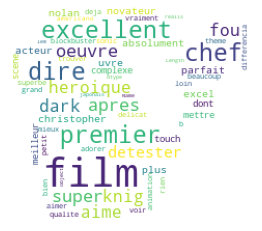

In [37]:
mask_pos = np.array(Image.open("pika_cloud.jpeg"))
mask_pos[mask_pos == 1] = 255

WC_pos = WordCloud(background_color="white", mask = mask_pos).generate(str(avis_positif))
plt.imshow(WC_pos)
plt.axis('off')
plt.show()

In [38]:
#Récupération des avis positifs négatifs
avis_negatif = df["lem"][y == 0]

avis_negatif

30      aujourd huir dire mode film scenario complique...
64      liberation apporter lors sortie salle commenta...
65      haaaaaa dire film crain froisser quelque un di...
67      inception rime plutot deception intriguer aval...
78      film mou ennuyer total histoire soulant quelqu...
                              ...                        
1588    film vraiment enfant fin film er merite note a...
1589    autant bon critique autant premier trouver ass...
1592    deconseiller enfant plus an long heure dialogu...
1600    beaucoup plus enfantin premier dommage ajout p...
1612    decevoir sonic scenario mieux travailler premi...
Name: lem, Length: 322, dtype: object

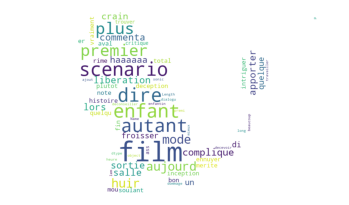

In [39]:
mask_neg = np.array(Image.open("salam_cloud.jpg"))
mask_neg[mask_neg < 255] = 0

WC_neg = WordCloud(background_color="white", mask = mask_neg).generate(str(avis_negatif))
plt.imshow(WC_neg)
plt.axis('off')
plt.show()

## Regréssion logistique

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
model_LR = LogisticRegression(solver="liblinear", random_state=0)

#Entrainement du modèle
# model_LR.fit(X_train, y_train)
model_LR.fit(df_bow, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [42]:
cv_X_test = cv.transform(X_test)
cv_X_test.shape

(420, 71)

In [43]:
X_test_bow = pd.DataFrame(cv_X_test.toarray(), index = X_test.index, columns = cv.get_feature_names_out())
X_test_bow

,acteur,action,aller,apres,assez,beaucoup,bien,bon,bref,carrey,...,scene,sonic,sortir,special,suite,super,toujours,video,voir,vraiment
2085,0,0,0,0,1,2,0,0,1,1,...,0,1,0,1,1,0,0,0,0,1
1941,0,0,0,0,0,2,0,0,0,0,...,1,5,0,0,0,1,1,0,0,0
1727,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
723,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,0,1,0,0,0,0,0,0,0,1,...,0,3,2,0,1,0,0,1,0,0
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1773,0,0,1,0,0,0,1,1,0,0,...,1,5,0,0,0,1,0,1,1,0


In [44]:
#Prédiction du y
y_pred = model_LR.predict(X_test_bow)

In [45]:
accuracy = model_LR.score(X_test_bow, y_test)
print(f"La précision est de {accuracy}")

La précision est de 0.8380952380952381


### Matrice de confusion

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
matrice_confusion = confusion_matrix(y_test, y_pred)
matrice_confusion

array([[ 25,  51],
       [ 17, 327]])

In [48]:
tn, fp, fn, tp = matrice_confusion.ravel()

print(f"True negative = {tn}, \nFalse positive = {fp}, \nFalse negative = {fn}, \nTrue positive = {tp}")

True negative = 25, 
False positive = 51, 
False negative = 17, 
True positive = 327
